## Easy 21 Reinforcement Learning Agent
##### Monte Carlo and SARSA agents to play Easy 21
##### (Linear Function Approximation agent to come)
From: https://www.davidsilver.uk/wp-content/uploads/2020/03/Easy21-Johannes.pdf

### Rules:
- Red and Black cards ranging from 1-10 in value
- Black cards are added to score, Red cards are subtracted from score
- Black cards occur with 2/3 probability, Red cards with 1/3 probability
- Agent and Dealer each start with 1 black card (agent can see dealer's card)
- Player can hit or stick on turn, once player sticks turn is over
- Agent goes first, then dealer
- Player with high score wins (bust if score > 21 or < 1)

In [1]:
import numpy as np
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

In [2]:
class Agent:
    def __init__(self, shape, epsilon=.9999, alpha=.1, gamma=.9):
        '''
        params: shape - ranges for player_sum, dealer_sum, num_actions for 
                        action/value approximation
                epsilon - exploration parameter
                alpha - step-size
                gamma - discount factor
                stick - boolean used to help determine if state is terminal
                values - action/value approximation
                running_total - agent score, used to calculate statistics for training runs
        '''
        self.stick = False
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.values = np.zeros((shape[0], shape[1], shape[2]))
        self.running_total = [0]
        
    def step(self, state, action):
        '''
        If player hits (0), deal card.  
        If player sticks (1), play out the dealer's turn
        '''
        if action == 0:
            state[0] += deal_card(False)
        else:
            self.stick = True
            while state[1] < 17 and state[1] >= 1:
                state[1] += deal_card(False)

        return give_reward(self, state)

    def choose_action(self, state, policy):
        greedy = np.random.random()
        if greedy > self.epsilon:
            action = policy[state[0] - 1][state[1] - 1]
        else:
            action = np.random.randint(2)
        return action
    
    def value_function(self):
        value_function = np.zeros((21,10))
        for i in range(len(self.values)):
            for j in range(len(self.values[i])):
                value_function[i][j] = np.max(self.values[i][j])
        return value_function   

In [3]:
def deal_card(is_first):
    '''
    First card for dealer and agent is black (positive value),
    for subsequent cards prob(black) = 2/3, prob(red) = 1/3
    '''
    value = np.random.randint(1,11)
    if is_first:
        return value
    else:
        color = np.random.random()
        if color < .33:
            value = 0 - value
        return value

In [4]:
def is_terminal(state, agent):
    if state[0] > 21 or state[0]< 1:
        return True

    elif agent.stick and (state[1] >= 17 or state[1] < 1):
        return True

    return False

In [5]:
def give_reward(agent, state):
    '''
    Reward = +1 (win), -1 (loss), 0 (tie or non-terminal state)
    '''
    if is_terminal(state, agent):
        if state[0] > 21 or state[0] < 1:
            agent.running_total.append((agent.running_total[-1] - 1))
            return -1
        elif state[1] > 21 or state[1] < 1:
            agent.running_total.append((agent.running_total[-1] + 1))
            return 1
        elif state[0] > state[1]:
            agent.running_total.append((agent.running_total[-1] + 1))
            return 1
        elif state[0] < state[1]:
            agent.running_total.append((agent.running_total[-1] - 1))
            return -1
    return 0

In [6]:
def monte_carlo(agent, num_episodes):
    '''
    Monte Carlo sampling run.  Action/value approximation: Q(s,a) = avg_return(s,a) 
    ε starts high to encourage exploration, steadily decreases as agent 
    learns better value approximations.  Policy starts as "hit" in every state, 
    becomes ε-greedy w.r.t. value function.
    '''
    policy = [[0 for i in range(10)] for i in range(21)]
    returns = [[[[],[]] for i in range(10)] for i in range(21)]

    for i in range(num_episodes):
        agent.stick = False
        agent.epsilon *= .9999
        G = 0
        state = [deal_card(True), deal_card(True)]
        while not is_terminal(state, agent):
            last_state = deepcopy(state)
            action = agent.choose_action(state, policy)
            reward = agent.step(state, action)
            G += reward
            returns[last_state[0] - 1][last_state[1] - 1][action].append(G)
            
            agent.values[last_state[0] - 1][last_state[1] - 1][action] = \
            np.average(returns[last_state[0] - 1][last_state[1] - 1][action])
            
            policy[last_state[0] - 1][last_state[1] - 1] = \
            np.argmax(agent.values[last_state[0] - 1][last_state[1] - 1])
    
    return policy
        

In [7]:
def sarsa(agent, num_episodes):
    '''
    SARSA Agent run.  Action/value approximation: 
    Q(s,a) = Q(s,a) + α(reward + γQ(s',a') - Q(s,a))
    ε held constant, policy starts as "hit" in all states,
    becomes ε-greedy w.r.t value function.
    '''
    policy = [[0 for i in range(10)] for i in range(21)]
    for i in range(num_episodes):
        agent.stick = False
        state = [deal_card(True), deal_card(True)]
        action = agent.choose_action(state, policy)
        while not is_terminal(state, agent):
            last_state = deepcopy(state)
            last_action = action
            reward = agent.step(state, action)
            
            if not is_terminal(state, agent):
                action = agent.choose_action(state, policy)
                agent.values[last_state[0] - 1][last_state[1] - 1][last_action] += \
                (agent.alpha * (reward + (agent.gamma * \
                agent.values[state[0] - 1][state[1] - 1][action]) - \
                agent.values[last_state[0] - 1][last_state[1] - 1][last_action]))
            else:
                agent.values[last_state[0] - 1][last_state[1] - 1][last_action] += \
                (agent.alpha * (reward - \
                agent.values[last_state[0] - 1][last_state[1] - 1][last_action]))

            policy[last_state[0] - 1][last_state[1] - 1] = \
            np.argmax(agent.values[last_state[0] - 1][last_state[1] - 1])
            
    return policy

In [8]:
def plot_value_function(val):
    '''
    plotting function from: https://github.com/mari-linhares/easy21/blob/master/easy21.ipynb
    '''
    fig = plt.figure("Value Function", figsize=(20, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    min_x = 1
    max_x = 10
    min_y = 1
    max_y = 21
    
    x_range = np.arange(min_x, max_x)
    y_range = np.arange(min_y, max_y)
    
    X, Y = np.meshgrid(x_range, y_range)
    
    def get_stat_val(x, y):
        return val[y, x]
    Z = get_stat_val(X, Y)
    
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    ax.set_zlabel('Value')
    return ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, 
                               linewidth=0, antialiased=False)

In [9]:
def plot_training_run(agent):
    episodes = np.array([i for i in range(1, len(agent.running_total))])
    moving_avg = np.array(agent.running_total[1:]) / episodes
    plt.plot(episodes[1000:], moving_avg[1000:])
    plt.xlabel("Number of Episodes")
    plt.ylabel("Winning Percentage")
    plt.show()

## Monte Carlo Agent Training Run

In [10]:
mc_agent = Agent([21,10,2])
policy = monte_carlo(mc_agent, 100000)

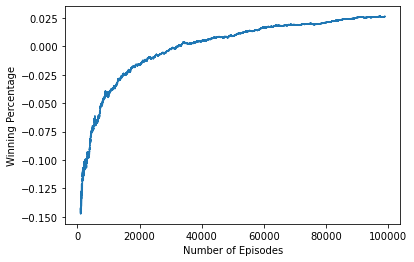

In [11]:
plot_training_run(mc_agent)

## Monte Carlo Agent Value Function

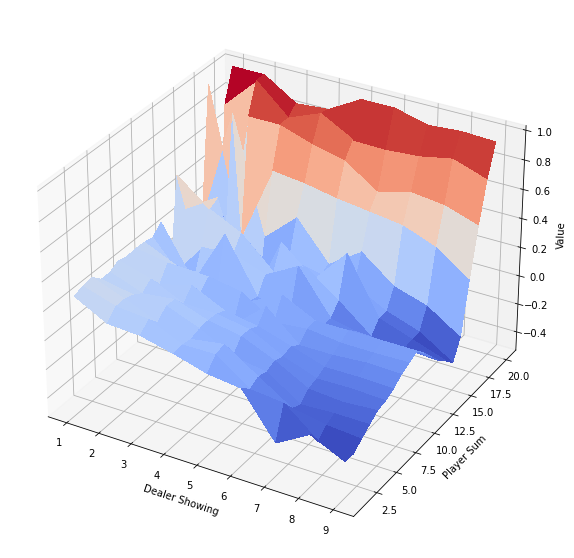

In [12]:
val = mc_agent.value_function()
plot_value_function(val)

## SARSA Agent Training Run

In [13]:
sarsa_agent = Agent([21,10,2], .15)
sarsa_policy = sarsa(sarsa_agent, 100000)

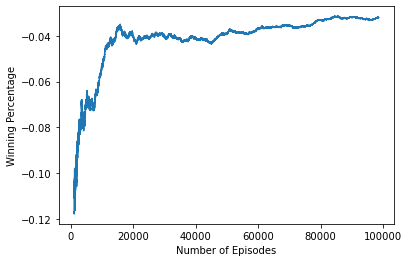

In [14]:
plot_training_run(sarsa_agent)

## SARSA Agent Value Function

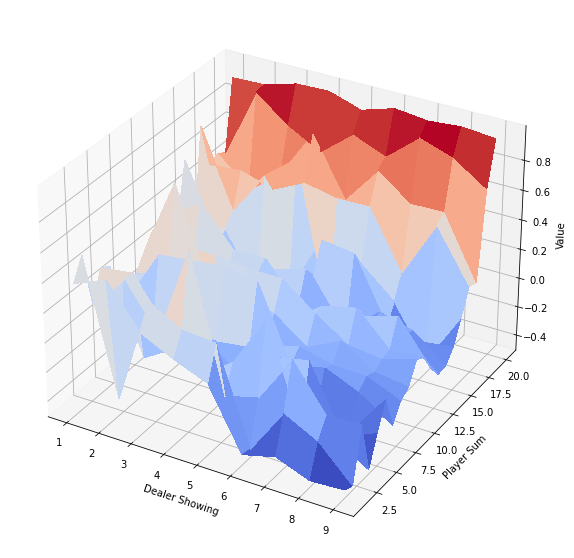

In [15]:
s_val = sarsa_agent.value_function()
plot_value_function(s_val)

## Mean Squared Error of SARSA Agent Value Function
Sarsa agent deviation from "true" value function learned
by Monte Carlo agent:  
MSE = Σ((Sarsa Q(s,a) - MC Q(s,a))^2

In [16]:
def compute_MSE(mc_agent, sarsa_agent):
    return np.sum((mc_agent.values - sarsa_agent.values)**2)

In [17]:
print(compute_MSE(mc_agent, sarsa_agent))

28.328426996895402
